### ISC CamCan Suspense

This notebook assesses the potential influence of motion (confounds)

### setting up modules

In [1]:
import os, sys, scipy, nilearn, warnings
warnings.filterwarnings("ignore")
import numpy as np
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import pandas as pd
#from pandas import DataFrame
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

from camcan_utils import *

/Users/Ralf/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### set up files

In [2]:
suspense_file         = '../../data/avg_suspense.npy'
dict_file             = '../../data/timeseries_dictionary.npy'
shen_dictionary_file  = '../../data/shen_dictionary.npy'
shen_atlas_filename   = '../../data/shen_2mm_268_parcellation.nii'
sample_file           = '../../data/func.nii'
dyn_isc_file          = '../../data/dyn_isc_dict.npy'

### load data

In [3]:
### load dynamic ISC results and reported suspense ratings

#see description in notebook on sliding window analysis
dyn_isc_dict       = np.load(dyn_isc_file, allow_pickle = True).item() 
dyn_isc_dict.keys()
dyn_isc_result_all = dyn_isc_dict['dyn_isc_result_all']       #this is the result across the full sample


suspense = np.load(suspense_file)

In [4]:
dyn_isc_result_all.shape

(193, 268)

In [5]:
# load the dictionary and create the main data structure (ts_data) as well as auxilliary variables.
read_dictionary = np.load(dict_file, allow_pickle = True).item()
subjs           = list(read_dictionary.keys())
n_subjs         = len(subjs)
n_tr, n_regions = read_dictionary[subjs[0]]['funcdata'].shape

ts_data         = np.zeros((n_tr, n_regions, n_subjs))
ts_data_undet   = np.zeros((n_tr, n_regions, n_subjs))
motion_data     = np.zeros((n_tr, 6, n_subjs))
age_data        = np.zeros((n_subjs))
gender_data     = np.zeros((n_subjs))

#loop over viewers and fill the ts_data array
for curr_sub in range(n_subjs):
    curr_sub_name = subjs[curr_sub]
    ts_data[:,:, curr_sub]     =  read_dictionary[curr_sub_name]['funcdata']
    motion_data[:,:, curr_sub] =  read_dictionary[curr_sub_name]['motion']
    age_data[curr_sub]         = read_dictionary[curr_sub_name]['age']
    gender_data[curr_sub]      = read_dictionary[curr_sub_name]['gender']

### quantify movement

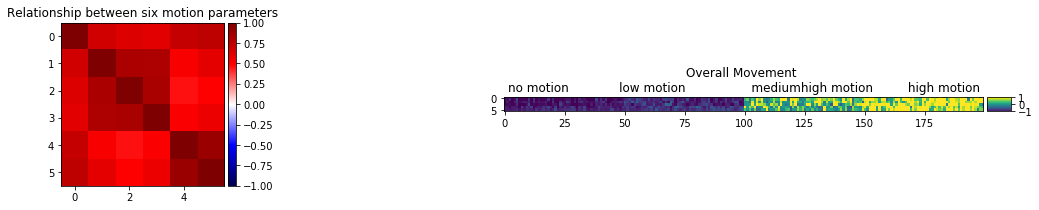

In [6]:
# one way to quantify overall amount of movement
n_mopar = 6
movement_quantification = np.zeros((n_mopar, n_subjs))
for subj in range(n_subjs):
    for mopar in range(n_mopar):
        movement_quantification[mopar, subj] = np.sum(np.abs(np.diff(motion_data[:,mopar,subj])))
 
plt.figure(figsize = (20,3))
plt.subplot(121)
ax = plt.gca()
im = ax.imshow(np.corrcoef(movement_quantification), cmap = 'seismic', vmin = -1, vmax = 1);
plt.title('Relationship between six motion parameters')
divider = make_axes_locatable(ax);
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax);
#plt.show()
# as can be seen, the by-subejct extent of motion is highly similar across the six parameters
# if a subject has a lot of motion in one, it also has much in the other parameter (x,y,z, y, r, g)
# this provides the basis for collapsing them and ranking subjects in the overall amount.

# rank this
movement_quantification_ranks = np.zeros(movement_quantification.shape)
for parameter in range(movement_quantification.shape[0]):
    order = movement_quantification[parameter,:].argsort()
    movement_quantification_ranks[parameter,:] = order.argsort()

# derive an overall metric
mean_rank = np.mean(movement_quantification_ranks, axis = 0)
order = mean_rank.argsort()
overall_rank = order.argsort()

# select the lowest ranking subjects (stifflers)
no_stiffler_indices = (np.where(overall_rank < 50))[0]
lo_stiffler_indices = np.setdiff1d(np.where( overall_rank < 100)[0], np.where(overall_rank < 50)[0] )

# select the highest ranking subjects (shakers)
high_shaker_indices = np.setdiff1d(np.where( overall_rank> (n_subjs-1) - 100)[0], np.where(overall_rank> (n_subjs-1) - 50)[0] )
highest_shaker_indices = (np.where(overall_rank > (n_subjs-1) - 50))[0]

# confirm that they differ markedly in movement
c = np.hstack((
     movement_quantification[:, no_stiffler_indices],
     movement_quantification[:, lo_stiffler_indices],
     movement_quantification[:, high_shaker_indices],
     movement_quantification[:, highest_shaker_indices]))

plt.subplot(122)
ax = plt.gca()
im = ax.imshow(scipy.stats.zscore(c.T).T, vmin = -1, vmax = 1);
plt.title('Overall Movement \nno motion             low motion                 mediumhigh motion         high motion')
divider = make_axes_locatable(ax);
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax);


### compute dynISC for subgroups separately

In [7]:
stiffler_shaker_list = [no_stiffler_indices,
                        lo_stiffler_indices,
                        high_shaker_indices,
                        highest_shaker_indices];

'''n_iterations = len(stiffler_shaker_list) #stifflers vs. shakers
dyn_isc_result_stiffler_shaker = np.zeros((n_iterations, n_tr, n_regions))

for curr_sample in range(n_iterations): 
    print(' Working on subgroup #', (curr_sample +1 ), ' of ', n_iterations)
    people_to_use = stiffler_shaker_list[curr_sample]
    D = ts_data[:,:, people_to_use ]
    dyn_isc_result_stiffler_shaker[curr_sample, :, :] = camcan_sliding_isc(D)

dyn_isc_dict_stiffler_shaker = {}
dyn_isc_dict_stiffler_shaker['dyn_isc_result_stiffler_shaker'] = dyn_isc_result_stiffler_shaker
np.save('../data/dyn_isc_dict_stiffler_shaker.npy', dyn_isc_dict) #'''

dyn_isc_dict_stiffler_shaker   = np.load('../../data/dyn_isc_dict_stiffler_shaker.npy', allow_pickle = True).item() 
dyn_isc_result_stiffler_shaker = dyn_isc_dict_stiffler_shaker['dyn_isc_result_stiffler_shaker']       #this is the result across the full sample

### Assert that dynamic ISC relates to suspense in motion-censored subgroups 
(across the brain and in regions/aMCC)

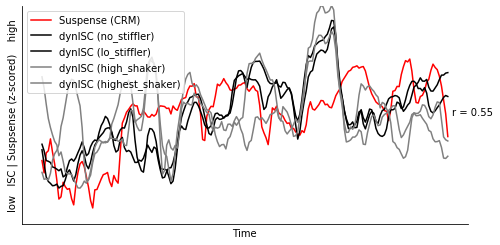

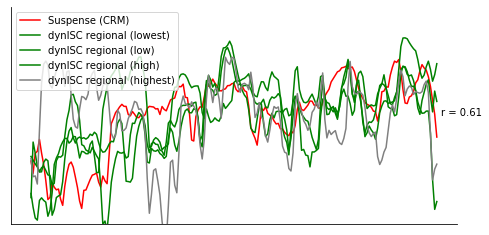

In [8]:
# across the brain
f = plt.figure(figsize=(8,4))
ax1 = f.add_subplot(111)
ax1.plot(scipy.stats.zscore(suspense),                                      color = 'red',   label = 'Suspense (CRM)'         );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result_stiffler_shaker[0,:,:], axis = 1)),   color = 'black', label = 'dynISC (no_stiffler)'   );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result_stiffler_shaker[1,:,:], axis = 1)),   color = 'black', label = 'dynISC (lo_stiffler)'   );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result_stiffler_shaker[2,:,:], axis = 1)),   color = 'gray',  label = 'dynISC (high_shaker)'   );
ax1.plot(scipy.stats.zscore(np.nanmean(dyn_isc_result_stiffler_shaker[3,:,:], axis = 1)),   color = 'gray',  label = 'dynISC (highest_shaker)');

alignment = np.corrcoef( (scipy.stats.zscore(np.nanmean(dyn_isc_result_stiffler_shaker[0,:,:], axis = 1)) ),
                          scipy.stats.zscore(suspense))[0,1]
text = ('r = ' + str(np.round(alignment, 2)) )
ax1.annotate(text, xy=(194, 0))

plt.legend(loc = 2)
plt.ylim(-3, 3)
plt.xlabel('Time')
plt.ylabel('low   ISC | Suspsense (z-scored)    high')
plt.xticks([]);
plt.yticks([]);
sns.despine()


# region 6 (aMCC)
curr_region = 6 
f = plt.figure(figsize=(8,4))
ax1 = f.add_subplot(111)
ax1.plot(scipy.stats.zscore(suspense),                         color = 'red'  , label = 'Suspense (CRM)'           );
ax1.plot(scipy.stats.zscore(dyn_isc_result_stiffler_shaker[0,:,curr_region]),  color = 'green', label = 'dynISC regional (lowest)' );
ax1.plot(scipy.stats.zscore(dyn_isc_result_stiffler_shaker[1,:,curr_region]),  color = 'green', label = 'dynISC regional (low)'    );
ax1.plot(scipy.stats.zscore(dyn_isc_result_stiffler_shaker[2,:,curr_region]),  color = 'green', label = 'dynISC regional (high)'   );
ax1.plot(scipy.stats.zscore(dyn_isc_result_stiffler_shaker[3,:,curr_region]),  color = 'gray' , label = 'dynISC regional (highest)');

alignment = np.corrcoef( (scipy.stats.zscore(dyn_isc_result_stiffler_shaker[1,:,curr_region]) ),
                          scipy.stats.zscore(suspense))[0,1]
text = ('r = ' + str(np.round(alignment, 2)) )
ax1.annotate(text, xy=(194, 0))

plt.legend(loc = 2)
plt.ylim(-3, 3)
plt.xticks([]);
plt.yticks([]);
sns.despine()

### Compute ISC/dynISC on motion data

In [9]:
# static ISC
D = motion_data
motionISC = camcan_isc(D, summary_statistic=np.mean, verbose = True)

# dynamic ISC (inclusive stability check)
# all viewers
D = motion_data;
dyn_motion_isc_result_all = camcan_sliding_isc(D)

# two subgroups
subject_chunks = [[0, int(n_subjs/2)], [int(n_subjs/2), n_subjs]]
n_iterations   = len(subject_chunks)
dyn_motion_isc_result     = np.zeros((n_iterations, n_tr, motion_data.shape[1]))
sub_index = np.arange(n_subjs)
np.random.shuffle(sub_index)
for curr_sample in range(n_iterations): 
    print('\nWorking on subgroup #', (curr_sample +1 ), ' of ', n_iterations)
    people_to_use = np.arange(subject_chunks[curr_sample][0], subject_chunks[curr_sample][1], 1)

    D = motion_data[:,:,sub_index[people_to_use] ]
    dyn_motion_isc_result[curr_sample, :, :] = camcan_sliding_isc(D)


Assuming 494 subjects with 193 time points and 6 voxel(s) or ROI(s).
Assuming 494 subjects with 193 time points and 6 voxel(s) or ROI(s).

99%
Working on subgroup # 1  of  2
Assuming 247 subjects with 193 time points and 6 voxel(s) or ROI(s).

99%
Working on subgroup # 2  of  2
Assuming 247 subjects with 193 time points and 6 voxel(s) or ROI(s).

99%

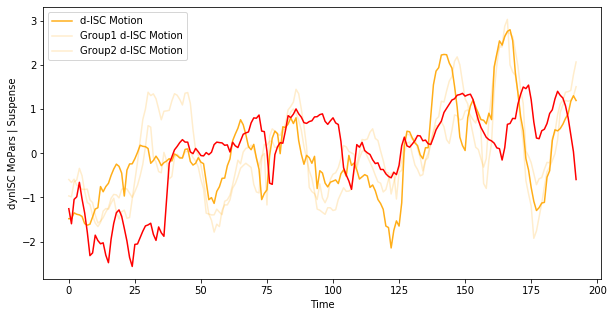

In [10]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)

ax1.plot(scipy.stats.zscore(dyn_motion_isc_result_all[:,0]), 
         alpha = 0.9, color = 'orange', label = 'd-ISC Motion');

ax1.plot(scipy.stats.zscore(np.mean(dyn_motion_isc_result[0,:,:], axis=1)), 
         alpha = 0.2, color = 'orange', label = 'Group1 d-ISC Motion');

ax1.plot(scipy.stats.zscore(np.mean(dyn_motion_isc_result[1,:,:], axis=1)), 
         alpha = 0.2, color = 'orange', label = 'Group2 d-ISC Motion');

ax1.plot(scipy.stats.zscore(suspense), color = 'red');
plt.legend();
plt.xlabel('Time');
plt.ylabel('dynISC MoPars | Suspense');

### Confirm that aggregate dynISC is not explained by motion 

i.e. that dynISC relates to reported suspense above and beyond motion

In [11]:
data_table = {'suspense'          : scipy.stats.zscore(suspense) ,
              'dyn_isc_motion'    : scipy.stats.zscore(np.nanmean(dyn_motion_isc_result_all[:,:], axis=1)),
              'dyn_isc_wholebrain': scipy.stats.zscore(np.nanmean(dyn_isc_result_all[:,:], axis=1))    }

df = pd.DataFrame(data_table, )
#sns.pairplot(df);
#plt.show()


mod = smf.ols(formula = 'suspense ~ dyn_isc_wholebrain + dyn_isc_motion', data = df)
res = mod.fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.334   
Dependent Variable: suspense         AIC:                473.3696
Date:               2019-08-26 21:54 BIC:                483.1577
No. Observations:   193              Log-Likelihood:     -233.68 
Df Model:           2                F-statistic:        49.05   
Df Residuals:       190              Prob (F-statistic): 6.69e-18
R-squared:          0.340            Scale:              0.66991 
-----------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept          -0.0000   0.0589 -0.0000 1.0000 -0.1162 0.1162
dyn_isc_wholebrain  0.4113   0.0598  6.8772 0.0000  0.2933 0.5293
dyn_isc_motion      0.3491   0.0598  5.8377 0.0000  0.2312 0.4671
-----------------------------------------------------------------
Omnibus:               24.744       Durbin-Watson:          0.107
Prob(Omnibus):         0.000        Jarque-Bera (JB):       9.225
Skew:                  -0.278       Prob(JB):               0.010
Kurtosis:              2.085        Condition No.:          1    
=================================================================

"""

### compute dynISC on low vs. high subgroups of viewers

compute ISC on motion data across subgroups with varying amounts of motion to confirm that motion doesn't track with suspense, and that ther is no longer synchronized motion among "stiff" subjects, yet the dynISC-suspense relationship is confirmed for these subjects

Assuming 50 subjects with 193 time points and 6 voxel(s) or ROI(s).

99%Assuming 50 subjects with 193 time points and 6 voxel(s) or ROI(s).

99%Assuming 50 subjects with 193 time points and 6 voxel(s) or ROI(s).

99%Assuming 50 subjects with 193 time points and 6 voxel(s) or ROI(s).

99%0.12
0.01
0.02
0.27


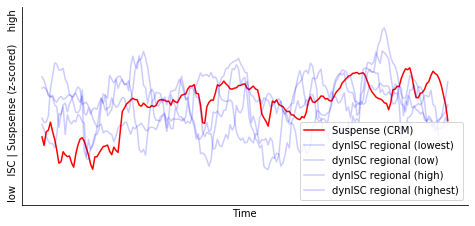

In [13]:
n_iterations = len(stiffler_shaker_list) #stifflers vs. shakers
dyn_isc_motion_result = np.zeros((n_iterations, n_tr, motion_data.shape[1]))

for curr_sample in range(n_iterations): 
    people_to_use = stiffler_shaker_list[curr_sample]
    D = motion_data[:,:,people_to_use ]
    dyn_isc_motion_result[curr_sample, :, :] = camcan_sliding_isc(D)


curr_region = 6 
shen_dictionary = np.load(shen_dictionary_file, allow_pickle = True).item()
curr_title = shen_dictionary[curr_region + 1]['name'] 
curr_coords = shen_dictionary[curr_region + 1]['coords'] 

f = plt.figure(figsize=(8,8))
region_vector = np.zeros((1,268))
region_vector[0,curr_region] = 0.5
#region_img = shen_masker.inverse_transform(region_vector);

curr_title = shen_dictionary[curr_region + 1]['name'] 
curr_coords = shen_dictionary[curr_region + 1]['coords'] 
    
ax1 = f.add_subplot(211)
ax1.plot(scipy.stats.zscore(suspense),                      color = 'red',  label = 'Suspense (CRM)');
ax1.plot(scipy.stats.zscore(dyn_isc_motion_result[0,:,0]),  color = 'blue', label = 'dynISC regional (lowest)'   , alpha = 0.2);
ax1.plot(scipy.stats.zscore(dyn_isc_motion_result[1,:,0]),  color = 'blue', label = 'dynISC regional (low)'      , alpha = 0.2);
ax1.plot(scipy.stats.zscore(dyn_isc_motion_result[2,:,0]),  color = 'blue', label = 'dynISC regional (high)'     , alpha = 0.2);
ax1.plot(scipy.stats.zscore(dyn_isc_motion_result[3,:,0]),  color = 'blue',  label = 'dynISC regional (highest)' , alpha = 0.2);


plt.legend(loc = 0)
plt.ylim(-4, 4)
plt.xlabel('Time')
plt.ylabel('low   ISC | Suspsense (z-scored)    high')
plt.xticks([]);
plt.yticks([]);
sns.despine()

#ax2 = f.add_subplot(212)    
#nilearn.plotting.plot_stat_map(nilearn.image.index_img(region_img,0),threshold = 0.45, vmax = 1., draw_cross = True,colorbar = False,
#                                       cmap = 'PuBu',  annotate = False,cut_coords = curr_coords,
#                                       title = str(curr_region),axes = ax2);
    
for i in range(4):
    print( np.round(np.corrcoef(scipy.stats.zscore(dyn_isc_motion_result[i,:,0]),
                                scipy.stats.zscore(suspense) )[0,1],2))

### double check that high-motion people actually have more motion and compare their averaged motion across groups

Assuming 494 subjects with 193 time points and 6 voxel(s) or ROI(s).
0.048862679054170056
0.015421145179846447
0.06783163234007997
0.05849305716222718


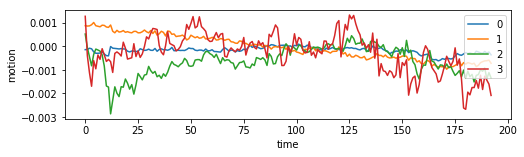

-0.07946079473396744
0.11260426289330355
0.15036467066360848
0.1929351864285061


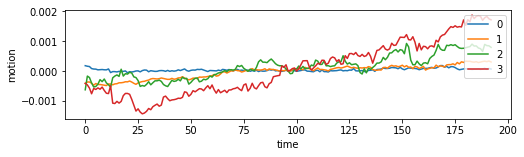

0.05945927430706623
0.030612842592421995
0.02177672038223355
0.09598327763512104


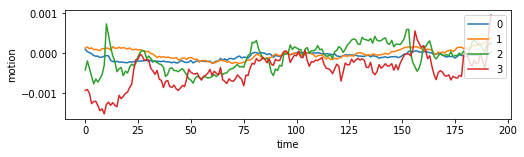

-0.029545743095540224
-0.0073651018677088256
0.2032873524016646
0.19790395202187394


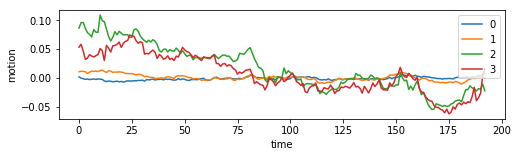

0.08050077951307273
0.08001352560661786
0.023224157450468793
0.040364301961222926


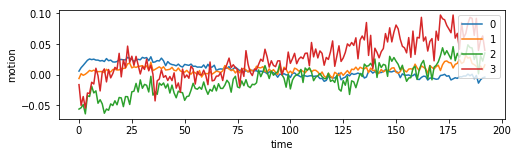

0.5600559570282957
0.1342749486724258
0.0706269687802597
0.094384941926178


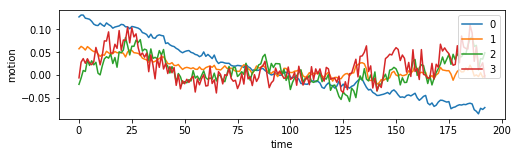

In [15]:
D = motion_data
motionISC = camcan_isc(D, summary_statistic=None, verbose = True)

for par in range(6):
    f = plt.figure(figsize=(8,2))

    for i in range(4):
        print(np.nanmean(motionISC[ stiffler_shaker_list[i],: ], axis=0)[par])
        m1mean = np.nanmean(motion_data[:, par, stiffler_shaker_list[i]], axis = 1)
        plt.plot((m1mean), label = str(i));

    plt.xlabel('time');
    plt.ylabel('motion');
    plt.legend(loc = 1)
    plt.show()